# Sparkify Project

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import sum as sparkSum, isnan, when, count, col, length, countDistinct, monotonically_increasing_id, collect_list
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder\
    .master("local")\
    .appName('Sparkify')\
    .getOrCreate()

# Load and Clean Dataset
Using tiny subset (128MB) of the full dataset available (12GB) for local development.

Mini dataset: `s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json`

Full dataset: `s3n://udacity-dsnd/sparkify/sparkify_event_data.json`


In [3]:
# Uncomment to download

# import requests
# url = 'https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json'

# def download_file(url):
#     local_filename = url.split('/')[-1]
#     with requests.get(url, stream=True) as r:
#         r.raise_for_status()
#         with open(local_filename, 'wb') as f:
#             for chunk in r.iter_content(chunk_size=8192): 
#                 f.write(chunk)
#     return local_filename

# download_file(url)

In [4]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [5]:
# Check schema and column types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
print('Number of rows mini dataset',df.count())
print('Number of columns mini dataset',len(df.columns))

Number of rows mini dataset 286500
Number of columns mini dataset 18


#### Let's check our data for numerical columns:

In [9]:
numCols = [col[0] for col in df.dtypes if not col[1]=='string']; numCols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [10]:
df.select(numCols).describe().show()

+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|        sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|  count|            286500|           228108|              278154|           286500|            286500|              286500|
|   mean|114.41421291448516|249.1171819778458|1.535358834084427...|1041.526554973822|210.05459685863875|1.540956889810483...|
| stddev|129.76726201140994|99.23517921058361| 3.291321616327586E9|726.7762634630741| 31.50507848842214|1.5075439608226302E9|
|    min|                 0|          0.78322|       1521380675000|                1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|             2474|               404|       1543799

#### Let's check our data for text columns:

In [11]:
text_cols = [col[0] for col in df.dtypes if col[1]=='string']; text_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

Although not expected by inspecting the data, `userId` is actually a string.

We check other information about our text data (not interested in `firstName` and `lastName`):

In [12]:
dist_artists = df.select(countDistinct('artist').alias('numberOfDistinctArtists')).withColumn("id", monotonically_increasing_id())

dist_songs = df.select(['song','artist']).groupBy('song').agg(countDistinct('artist').alias('countDistinctArtists')).\
    select(sparkSum('countDistinctArtists').alias('numberOfDistinctSongs')).withColumn("id", monotonically_increasing_id())

dist_user_agents = df.select(countDistinct('userAgent').alias('numberOfuserAgents')).withColumn("id", monotonically_increasing_id())

dist_locations = df.select(countDistinct('location').alias('numberOfDistinctLocations')).withColumn("id", monotonically_increasing_id())

text_cols_info = dist_artists.join(dist_songs, "id", "outer")\
                             .join(dist_user_agents, "id", "outer")\
                             .join(dist_locations, "id", "outer").drop('id')\

text_cols_info.show()

+-----------------------+---------------------+------------------+-------------------------+
|numberOfDistinctArtists|numberOfDistinctSongs|numberOfuserAgents|numberOfDistinctLocations|
+-----------------------+---------------------+------------------+-------------------------+
|                  17655|                65416|                56|                      114|
+-----------------------+---------------------+------------------+-------------------------+



Sparkify's mini dataset contains has 17655 different artists, 65416 songs, users in 114 different locations that use 56 different types of devices/software to access the app.

In [13]:
# We calculate value counts for:
text_cols_value_counts = ['auth',
                         'gender',
                         'level',
                         'method',
                         'page']

for column in text_cols_value_counts:
    df.select(column).groupBy(column).count().orderBy('count').show(30, truncate=False)

+----------+------+
|auth      |count |
+----------+------+
|Cancelled |52    |
|Guest     |97    |
|Logged Out|8249  |
|Logged In |278102|
+----------+------+

+------+------+
|gender|count |
+------+------+
|null  |8346  |
|M     |123576|
|F     |154578|
+------+------+

+-----+------+
|level|count |
+-----+------+
|free |58338 |
|paid |228162|
+-----+------+

+------+------+
|method|count |
+------+------+
|GET   |25436 |
|PUT   |261064|
+------+------+

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Submit Registration      |5     |
|Register                 |18    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Submit Downgrade         |63    |
|Submit Upgrade           |159   |
|Error                    |258   |
|Save Settings            |310   |
|Upgrade                  |499   |
|About                    |924   |
|Settings                 |1514  |
|Help                     |1726  |
|Downgrade   

#### Loading, cleaning the dataset and checking for invalid or missing data - for example, records without userids or sessionids. 

In [19]:
#Checking if there are NaNs
df.select([count(when(isnan(c), c)).alias(c+'IsNan') for c in df.columns]).toPandas()

,artistIsNan,authIsNan,firstNameIsNan,genderIsNan,itemInSessionIsNan,lastNameIsNan,lengthIsNan,levelIsNan,locationIsNan,methodIsNan,pageIsNan,registrationIsNan,sessionIdIsNan,songIsNan,statusIsNan,tsIsNan,userAgentIsNan,userIdIsNan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No Nans in the mini-dataset.

In [20]:
#Checking if there are null values
df.select([count(when(col(c).isNull(), c)).alias(c+'IsNull') for c in df.columns]).toPandas()

,artistIsNull,authIsNull,firstNameIsNull,genderIsNull,itemInSessionIsNull,lastNameIsNull,lengthIsNull,levelIsNull,locationIsNull,methodIsNull,pageIsNull,registrationIsNull,sessionIdIsNull,songIsNull,statusIsNull,tsIsNull,userAgentIsNull,userIdIsNull
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Appearently missing data is correlated (missing counts of columns consistently appear having 8346 or 58392 Null values).

Let's check userId:

In [104]:
# userId is string and shold be always with length greater than 0
df.select('userId', length(col('userId')).alias('userIdLength')).distinct().orderBy(col('userIdLength')).show(5)

+------+------------+
|userId|userIdLength|
+------+------------+
|      |           0|
|     6|           1|
|     3|           1|
|     5|           1|
|     4|           1|
+------+------------+
only showing top 5 rows



Looks like there are users with userId equals to `''` (length of the string userId is zero). We'll drop them from our dataframe:

In [106]:
# Drop userId equals to ''
df = df.filter(df.userId!='')

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

Let's check how missing values are correlated:

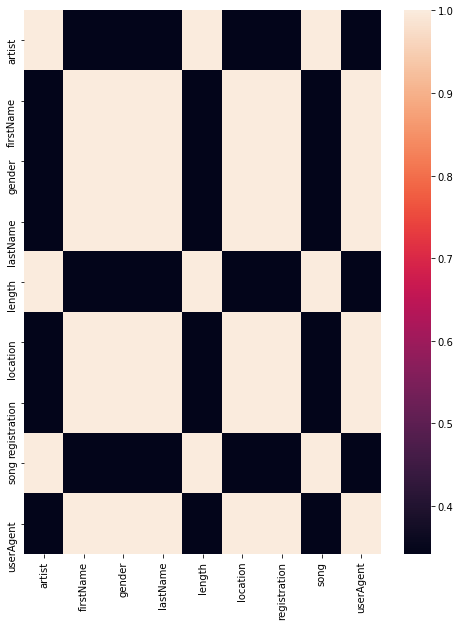

In [111]:
# Check null values: 1 is null and 0 not null
df_is_null = df.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df.columns])

df_is_null_describe = df_is_null.describe()

df_is_null_describe = df_is_null_describe.filter(
    (df_is_null_describe['summary']=='stddev') | 
    (df_is_null_describe['summary'] == 'max')
)

# Handle the std equals to zero (all values are the same) and without any null value
zero_std_max_cols = [col for col in df_is_null_describe.columns if df_is_null_describe.select(collect_list(col)).head().asDict()['collect_list('+col+')'] == ['0.0', '0']]

# Drop all columns with Standard Deviation equals zero and no missing values
df_is_null = df_is_null.drop(*zero_std_max_cols)

# Create vectors 
assembler = VectorAssembler(inputCols=df_is_null.columns, outputCol='vector')
assembled = assembler.transform(df_is_null).drop(*df_is_null.columns)

# Calculate and print Pearson correlation matrix for missing values
pearson_corr = Correlation.corr(assembled, 'vector').head()
pearson_corr = pd.DataFrame(data=pearson_corr[0].toArray(), columns=df_is_null.columns, index=df_is_null.columns)

fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pearson_corr, ax=ax);

When there's a null in `artist` column also a null in `length` and `song` happen. Hence, this data may be related and length appears to be the length in seconds of songs. 

Similarly, data related to users are related and when a null happens in either `firstName`, `lastName`, `gender`, `location`, `userAgent` and `registration` the others are null too. The column registration seems to be related to the timestamp of when a user registers himself/herself in the application.

# Exploratory Data Analysis

### Define Churn

We create a column `Churn` to use as the label for our model. We choose the `Cancellation Confirmation` events to define the churn, which happen for both paid and free users. We also analyze the `Downgrade` events.

### Explore Data
Analyzing the behavior for users who stayed vs users who churned. 
We explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# How many songs do users listen to on average between visiting our home page

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

In [ ]:
cusum.show()

In [ ]:
# Calculating Statistics by Hour

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

user_log = user_log.withColumn("hour", get_hour(user_log.ts))

user_log.head()

songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

songs_in_hour.show()

songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [ ]:
# Drop Rows with Missing Values
# As wee see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

user_log_valid.count()

user_log.select("userId").dropDuplicates().sort("userId").show()

user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

user_log_valid.count()

In [ ]:
# Users Downgrade Their Accounts
# We find when users downgrade their accounts and then flag those log entries. Then we use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

user_log_valid.filter("page = 'Submit Downgrade'").show()

user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

user_log_valid.head()

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

# Feature Engineering

# Modeling
We split the full dataset into train, test, and validation sets. 

We evaluate the accuracy of the various models, tuning parameters as necessary. 

The winning model is chosen based on test accuracy and we report the results of the model on the validation set. Since the churned users are a fairly small subset, we use F1 score as the metric to optimize.

# Final Steps